In [16]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import torch
import pickle
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_8DLorenz.recursive_LSTM_PostMeanScore_8DLorenz_T256_H05_tl_110data import \
    get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

In [18]:
config = get_config()
deltaT = config.deltaT
print(config.loss_factor)

2


In [19]:
def get_drift_files(config):
    ts_type = f"{config.ndims}DLorenz"
    include =  (f"_{1}NDT_{config.loss_factor}LFac_{round(config.forcing_const,3)}FConst").replace(
            ".", "")
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_dir):
        if "LSTM" in file and ts_type in file and include in file:
            if "OOSDriftTrack" in file and "true" in file:
                driftoostrack_true_files.append(root_dir+file)
            elif "OOSDriftTrack" in file and "local" in file:
                driftoostrack_local_files.append(root_dir+file)
    assert len(driftoostrack_true_files)>0, "No oos drift track files found"
    assert len(driftoostrack_local_files)>0, "No oos drift track files found"
    assert(len(driftoostrack_true_files) == len(driftoostrack_true_files))
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    return driftoostrack_true_files[:-8], driftoostrack_local_files[:-8], Nepochs_track[:-8]

In [20]:
drift_true_files, drift_local_files, Nepochs = get_drift_files(config)
Nepochs

[10,
 12,
 14,
 16,
 18,
 102,
 104,
 106,
 108,
 110,
 112,
 114,
 116,
 118,
 120,
 122,
 124,
 126,
 128,
 130,
 132,
 134,
 136,
 138,
 140,
 142,
 144,
 146,
 148,
 152,
 154,
 156,
 158,
 160,
 162,
 164,
 166,
 168,
 170,
 172,
 174,
 176,
 178,
 180,
 182,
 184,
 186,
 188,
 190,
 192,
 194,
 196,
 1000,
 1002,
 1004,
 1006,
 1008,
 1010,
 1012,
 1014,
 1016,
 1018,
 1020,
 1022,
 1024,
 1026,
 1028,
 1030,
 1032,
 1034,
 1036,
 1038,
 1040,
 1042,
 1044,
 1046,
 1048,
 1050,
 1052,
 1054,
 1056,
 1058,
 1060,
 1062,
 1064,
 1066,
 1068,
 1070,
 1072,
 1074,
 1076,
 1078,
 1080,
 1082,
 1084,
 1086,
 1088,
 1090,
 1092,
 1094,
 1096,
 1098,
 1100,
 1102,
 1104,
 1106,
 1108,
 1110,
 1112,
 1114,
 1116,
 1118,
 1120,
 1122,
 1124,
 1126,
 1128,
 1130,
 1132,
 1134,
 1136,
 1138,
 1140,
 1142,
 1144,
 1146,
 1148,
 1150,
 1152,
 1154,
 1156,
 1158,
 1160,
 1162,
 1164,
 1166,
 1168,
 1170,
 1172,
 1174,
 1176,
 1178,
 1180,
 1182,
 1184,
 1186,
 1188,
 1190,
 1192,
 1194,
 1196,


In [21]:
drift_track_rmses = {}
for f in zip(*[Nepochs, drift_true_files, drift_local_files]):
    Nepoch = f[0]
    true = f[1]
    local = f[2]
    try:
        all_true_states = np.load(true)/np.sqrt(config.deltaT)
        all_local_states= np.load(local)/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
    except FileNotFoundError as e:
        print(e)
        continue
drift_track_rmses

{10: 0.4047815836007257,
 12: 0.3705406896463011,
 14: 0.36379641530208906,
 16: 0.3597629637973099,
 18: 0.3552717065347719,
 102: 0.2165028291458432,
 104: 0.21878933461642985,
 106: 0.20924316262128007,
 108: 0.21618438527801304,
 110: 0.2091831080727772,
 112: 0.21213702183552105,
 114: 0.2102048552261348,
 116: 0.20905228296071837,
 118: 0.210594461546118,
 120: 0.21661640404118737,
 122: 0.21014723281569755,
 124: 0.2100449159955836,
 126: 0.21834949053448507,
 128: 0.2093622173831362,
 130: 0.21063280344641475,
 132: 0.21039096835153806,
 134: 0.21159384102524825,
 136: 0.21122391921970488,
 138: 0.20743287482559877,
 140: 0.2091632760355909,
 142: 0.20998872667943433,
 144: 0.20911221539382482,
 146: 0.21115796346522958,
 148: 0.21589118582481479,
 152: 0.21010043718080462,
 154: 0.21369845233669435,
 156: 0.20484979475681336,
 158: 0.2039713863012639,
 160: 0.2019074683317866,
 162: 0.20417761580302973,
 164: 0.20273478853102095,
 166: 0.20568676385266324,
 168: 0.208178696190

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0.8963343367250068

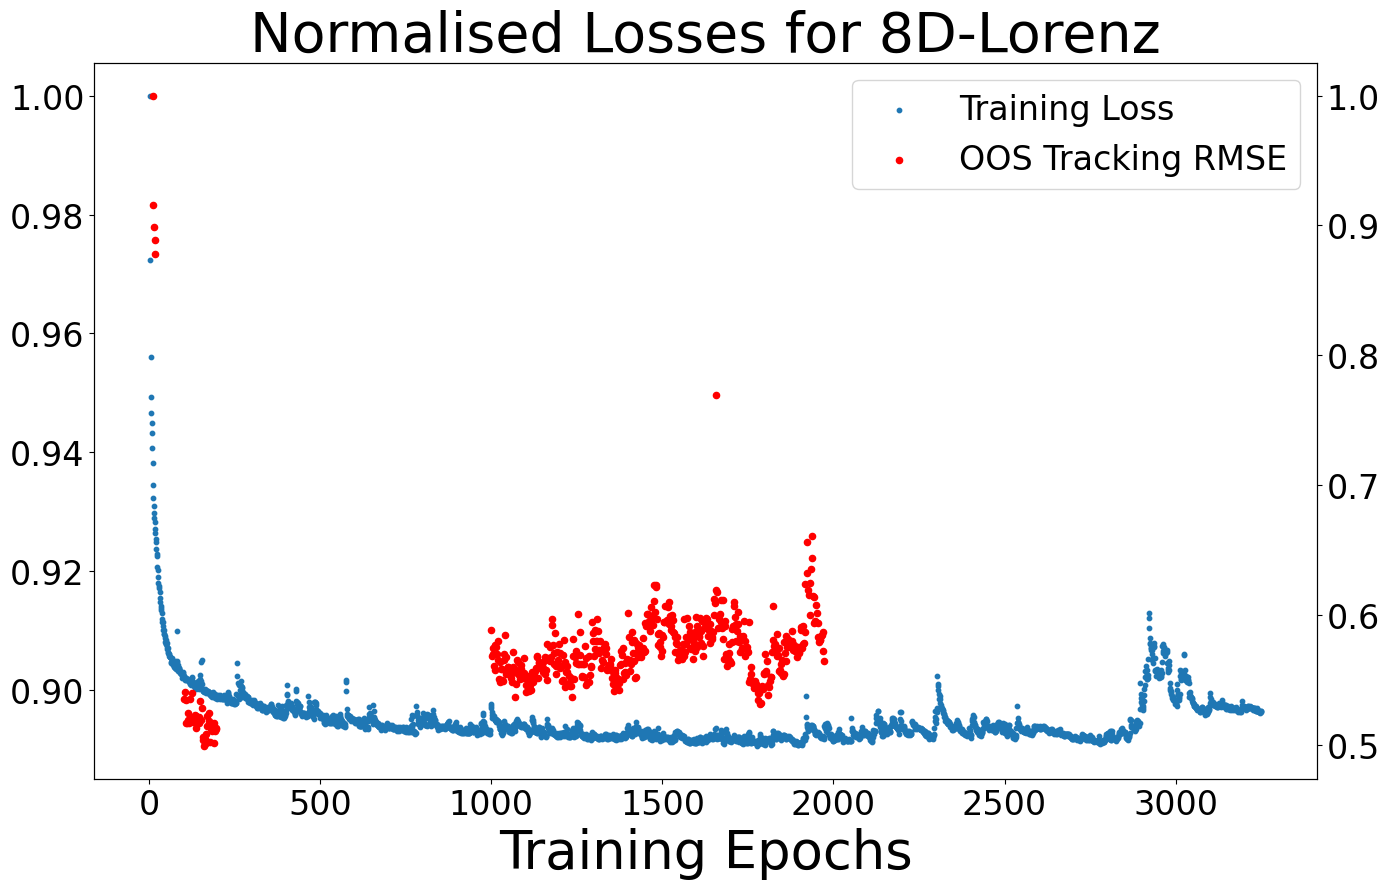

In [26]:
%load_ext autoreload
%autoreload 2
from configs.RecursiveVPSDE.LSTM_8DLorenz.recursive_LSTM_PostMeanScore_8DLorenz_T256_H05_tl_110data import \
    get_config
config = get_config()
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.sqrt(np.array(pickle.load(f)).astype(float))
start_idx = 2
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(np.arange(start_idx, losses.shape[0]), losses[start_idx:]/losses[start_idx], s=10, label="Training Loss")
ax.tick_params(axis="both",labelsize=24)
ax2 = ax.twinx()
track_rmses = list(drift_track_rmses.values())
track_rmses /= track_rmses[0]
sc2 = ax2.scatter(Nepochs, track_rmses, s=20, color="red",label="OOS Tracking RMSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(r"Normalised Losses for 8D-Lorenz", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
#ax.set_yscale("log")
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
#plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/f8DLnz_DriftEvalExpLosses_PM_LSTM_{round(config.loss_factor,3)}FConst").replace(".", "")+".png")
losses[-1]/losses[start_idx]

In [23]:
raise RuntimeError

RuntimeError: 

In [ ]:
curr_rmse = np.inf
toSave = False
for Nepoch in config.max_epochs:
    try:
        num_diff_times = 1
        save_path = (
                project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_{config.ndims}DLorenz_OOSDriftTrack_{Nepoch}Nep_tl{config.tdata_mult}data_{config.t0}t0_{config.deltaT:.3e}dT_{num_diff_times}NDT_{config.loss_factor}LFac_{round(config.forcing_const,3)}FConst").replace(
            ".", "")
        all_true_states = np.load(save_path + "_global_true_states.npy")/np.sqrt(config.deltaT)
        all_local_states= np.load(save_path + "_local_states.npy")/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        total_local_errors_minq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], curr_rmse)
        if total_local_errors[-1] < curr_rmse:
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(time_steps, total_local_errors)
            #plt.fill_between(time_steps, total_local_errors_minq, total_local_errors_maxq, color="blue", alpha=0.2, label="95% Confidence Band")
            plt.errorbar(time_steps,total_local_errors,yerr=[total_local_errors-total_local_errors_minq, total_local_errors_maxq-total_local_errors],xerr=None, fmt='o', color="blue", alpha=0.4)

            ax.set_title(f"Cumulative RMSE for LSTM Score Estimator",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/4DLnz_OOSDriftTrack_{Nepoch}Nep_PM_LSTM_{config.forcing_const}FConst").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} with final IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at Nepoch {Nepoch} for {config.forcing_const}FConst\n")
    except FileNotFoundError as e:
        continue